In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
#from scipy.spatial import cKDTree


In [2]:
class DataCloud:
    N = 0  # Contador global de nuvens de dados
    
    def __init__(self, x):
        #Inicializa uma nova nuvem de dados com o primeiro ponto x
        self.n = 1  # Número de pontos na nuvem
        self.mean = x  # Média (centroide)
        self.variance = 0  # Variância inicial (0 para um único ponto)
        self.pertinency = 1  # Grau de pertinência
        DataCloud.N += 1  # Incrementa contador global

    def updateDataCloud(self , x):
        """Atualiza a nuvem com um novo ponto x usando as Eqs.recursivas 4 e 5 do artigo"""
        old_mean = self.mean
        old_variance = self.variance

        # Atualiza média (Eq. 4)
        self.mean = ((self.n - 1) * old_mean + x) / self.n

        # Atualiza variância (Eq. 5 corrigida, usando old_mean em vez da média já atualizada)
        self.variance = ((self.n - 1) / self.n) * old_variance + (1 / self.n) * np.linalg.norm(x - old_mean)**2

        self.n += 1  # Incrementa contador de pontos
        
        # Proteção contra variância zero após atualização
        self.variance = max(self.variance, 1e-6)


In [ ]:
class AutoCloud():
    def __init__(self, m=2.5):  # Valor padrão (default) caso o usuário não especifique
        self.m = m  # Parâmetro de sensibilidade (Eq. 9)
        self.clouds = []  # Lista de DataClouds
        self.classIndex = []  # Histórico de classificações
        self.k = 0  # Contador de amostras processadas

        # Dicionário para rastrear amostras processadas
        self.sample_registry = {}


    def calculate_eccentricity(self, x, cloud):
        """Calcula a excentricidade normalizada (Eqs. 3 e 12)"""
        if cloud.n == 0 or cloud.variance == 0:
            return 1.0  # Máxima excentricidade se não houver dados
    
        term1 = 1 / cloud.n
        diff = cloud.mean - x
        term2 = (diff.T @ diff) / (cloud.n * cloud.variance)
        
        return term1 + term2  # Sem divisão por 2!


    def merge_clouds(self):
        """Fusão de clouds baseada na sobreposição das amostras (Eqs. 16-20)"""
        
        epsilon = 1e-6  # 🔹 Evita threshold = 0 se variância for zero
        
        i = 0
        while i < len(self.clouds):
            j = i + 1
            while j < len(self.clouds):
                # Calcula distância euclidiana entre as médias
                mean_diff = np.linalg.norm(self.clouds[i].mean - self.clouds[j].mean)
                
                # Proteção contra variância zero só na fusão
                var_i = self.clouds[i].variance + epsilon
                var_j = self.clouds[j].variance + epsilon
                threshold = self.m * (np.sqrt(var_i) + np.sqrt(var_j))

                if mean_diff < threshold:  # Usa Eq. 16 como critério de fusão
                    # Atualiza parâmetros da nova nuvem fundida (Eqs. 17-20)
                    ni, nj = self.clouds[i].n, self.clouds[j].n
                    mean_i, mean_j = self.clouds[i].mean, self.clouds[j].mean
                    var_i, var_j = self.clouds[i].variance, self.clouds[j].variance

                    # Atualiza número de pontos
                    self.clouds[i].n = ni + nj

                    # Atualiza média (Eq. 18)
                    self.clouds[i].mean = (ni * mean_i + nj * mean_j) / (ni + nj)

                    # Atualiza variância corretamente (Eq. 17)
                    self.clouds[i].variance = (ni * var_i + nj * var_j + 
                                            (ni * nj * np.linalg.norm(mean_i - mean_j) ** 2) / (ni + nj)) / (ni + nj)

                    # Atualiza classIndex com realocação de índices
                    for k, idx in enumerate(self.classIndex):
                        if idx == j:
                            self.classIndex[k] = i
                        elif idx > j:
                            self.classIndex[k] -= 1

                    # Remove `cloud j`
                    self.clouds.pop(j)
                    continue  # Mantém `i` fixo para reavaliar após fusão

                j += 1
            i += 1


    def calculate_quality(self):
        """Calcula a métrica de qualidade das fusões das clouds, baseada na Eq. 21 do artigo."""
        # Casos especiais
        if len(self.clouds) < 2:
            return 0.0

        total = 0.0
        min_distance = float('inf')
        eps = 1e-10  # Valor pequeno para evitar divisão por zero

        # Calcula a soma ponderada das variâncias
        for cloud in self.clouds:
            eccentricity = self.calculate_eccentricity(cloud.mean, cloud)
            typicality = max(0, 1 - (2 * eccentricity))  # Evita valores negativos
            total += (typicality**2) * (cloud.variance + eps)

        # Encontra a menor distância entre centróides de clusters distintos
        for i, c1 in enumerate(self.clouds):
            for j, c2 in enumerate(self.clouds):
                if i < j:
                    distance = np.linalg.norm(c1.mean - c2.mean)
                    if distance > eps:  
                        min_distance = min(min_distance, distance)

        # Se todos clusters forem muito próximos (possivelmente ruins)
        if min_distance == float('inf'):
            return 0.0

        # Cálculo final com proteção contra zero no denominador
        denominator = len(self.clouds) * max(min_distance, eps)
        return total / denominator


    def run(self, x):
        if self.k < 20 or self.k % 5000 == 0:
            print(f"[k={self.k}] x = {x}")

        self.k += 1
        x = np.array(x)  # Garante que x seja um numpy array

        # Passo 1: Processamento das primeiras 2 amostras (mantido do original)
        if self.k == 1:
            self.clouds.append(DataCloud(x))
            self.classIndex.append(0)
            return

        if self.k == 2:
            self.clouds[0].updateDataCloud(x)
            self.classIndex.append(0)
            return

        # Passo 2: Para k >= 3 - FASE DE AVALIAÇÃO (otimizada)
        closest_cloud = None
        min_ecc = float('inf')
        threshold_factor = (self.m**2 + 1) / 3  # 🔹 Cálculo movido para evitar redundância 

        for i, cloud in enumerate(self.clouds):
            ecc = self.calculate_eccentricity(x, cloud)
            threshold = threshold_factor / cloud.n  # 🔹 Movido para dentro do loop para evitar cálculos repetidos
            
            if ecc <= threshold and ecc < min_ecc:
                closest_cloud = i
                min_ecc = ecc

        # Passo 3: FASE DE ATUALIZAÇÃO de Nuvens (otimizada)
        if closest_cloud is not None:
            cloud = self.clouds[closest_cloud]
            
            n_old = cloud.n  # 🔹 Guarda o valor antigo de `n`
            n_new = n_old + 1  # Não incrementa `cloud.n` aqui!

            old_mean = cloud.mean  # 🔹 Armazena a média antes da atualização

            # Atualiza média (Eq. 4)
            cloud.mean = (n_old / n_new) * cloud.mean + (1 / n_new) * x

            # Atualiza variância com tratamento especial se for o segundo ponto da nuvem
            if n_old == 1:
                cloud.variance = np.linalg.norm(x - old_mean) ** 2
            else:
                cloud.variance = ((n_old - 1) / n_old) * cloud.variance + (1 / n_new) * np.linalg.norm(x - old_mean) ** 2
            
            cloud.variance = max(cloud.variance, 1e-6)  # Proteção contra variância zero
            cloud.n = n_new  # Só agora atualiza o contador de amostras da cloud

            self.classIndex.append(closest_cloud)

        else:
            # Novo critério de fallback baseado em distância ao centróide
            for i, cloud in enumerate(self.clouds):
                # Distância Euclidiana entre x e o centróide da cloud
                dist = np.linalg.norm(x - cloud.mean)
                
                # Critério: atualiza se a distância for pequena o suficiente
                if dist < 0.75:  #Ajuste este valor conforme necessário
                    cloud.updateDataCloud(x)
                    self.classIndex.append(i)
                    break
            else:
                self.clouds.append(DataCloud(x))
                self.classIndex.append(len(self.clouds) - 1)

        # Passo 4: Fusão periódica (mantido do original)
        if self.k % 60 == 0:
            self.merge_clouds()


In [4]:
#Loop Loopinho
if __name__ == "__main__":
    import time

    # Carregar dados
    df = pd.read_csv('entropia_tcp_stream.csv', sep=',')
    features = df[['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.urg', 'tcp.time_delta']].values

    # Criar e executar AutoCloud
    ac = AutoCloud(m=1.5)

    start_time = time.time()  # 🔹 Inicia medição do tempo

    for i, x in enumerate(features[:88000]):  
        ac.run(x)

        if i % 100 == 0 and i > 0:  # 🔹 Evita exibir na iteração 0
            elapsed = time.time() - start_time
            estimated_total = (elapsed / i) * 5000
            remaining_time = estimated_total - elapsed

            print(f"Processadas {i} amostras, {len(ac.clouds)} clouds criadas")
            print(f"Qualidade atual: {ac.calculate_quality():.4f}")
            #print(f"Tempo estimado restante: {remaining_time:.2f}s")  # 🔹 Mostra tempo estimado

    # Testes adicionais
    print("\nTestes de consistência:")
    print(f"Total de amostras processadas: {len(ac.classIndex)}")
    print(f"Soma de amostras registradas nas clouds: {sum(cloud.n for cloud in ac.clouds)}")
    print(f"Frequência de clouds:\n{Counter(ac.classIndex)}")
    
    # Escolher as clouds mais populosas para análise
    cloud_counts = Counter(ac.classIndex)
    
    # Exibir estatísticas das clouds
    print("\nResultados finais:")
    print(f"Total de clouds: {len(ac.clouds)}")
    print(f"Métrica de qualidade: {ac.calculate_quality():.4f}")

    for i, cloud in enumerate(ac.clouds):
        num_amostras = cloud_counts.get(i, 0)
        print(f"\nCloud {i}:")
        print(f"  Núm. amostras: {cloud.n}")
        print(f"  Centróide: {cloud.mean}")
        print(f"  Variância: {cloud.variance:.4f}")
        print(f"  Amostras associadas: {num_amostras}")


[k=0] x = [0. 0. 0. 0. 0.]
[k=1] x = [-1.44269516e-10 -1.44269516e-10  1.00000000e+00 -1.44269516e-10
 -1.44269516e-10]
[k=2] x = [-1.44269516e-10 -1.44269516e-10  9.18295834e-01 -1.44269516e-10
 -1.44269516e-10]
[k=3] x = [-1.44269516e-10 -1.44269516e-10  8.11278124e-01 -1.44269516e-10
 -1.44269516e-10]
[k=4] x = [-1.44269516e-10 -1.44269516e-10  7.21928095e-01 -1.44269516e-10
 -1.44269516e-10]
[k=5] x = [ 6.50022421e-01 -1.44269516e-10  9.18295834e-01 -1.44269516e-10
 -1.44269516e-10]
[k=6] x = [ 8.63120568e-01 -1.44269516e-10  9.85228136e-01 -1.44269516e-10
  5.91672778e-01]
[k=7] x = [ 8.11278124e-01 -1.44269516e-10  1.00000000e+00 -1.44269516e-10
  5.43564443e-01]
[k=8] x = [ 7.64204506e-01 -1.44269516e-10  9.91076060e-01 -1.44269516e-10
  5.03258334e-01]
[k=9] x = [ 7.21928095e-01 -1.44269516e-10  9.70950594e-01 -1.44269516e-10
  4.68995593e-01]
[k=10] x = [ 6.84038435e-01 -1.44269516e-10  9.45660304e-01 -1.44269516e-10
  4.39496987e-01]
[k=11] x = [ 6.50022421e-01 -1.44269516e-1

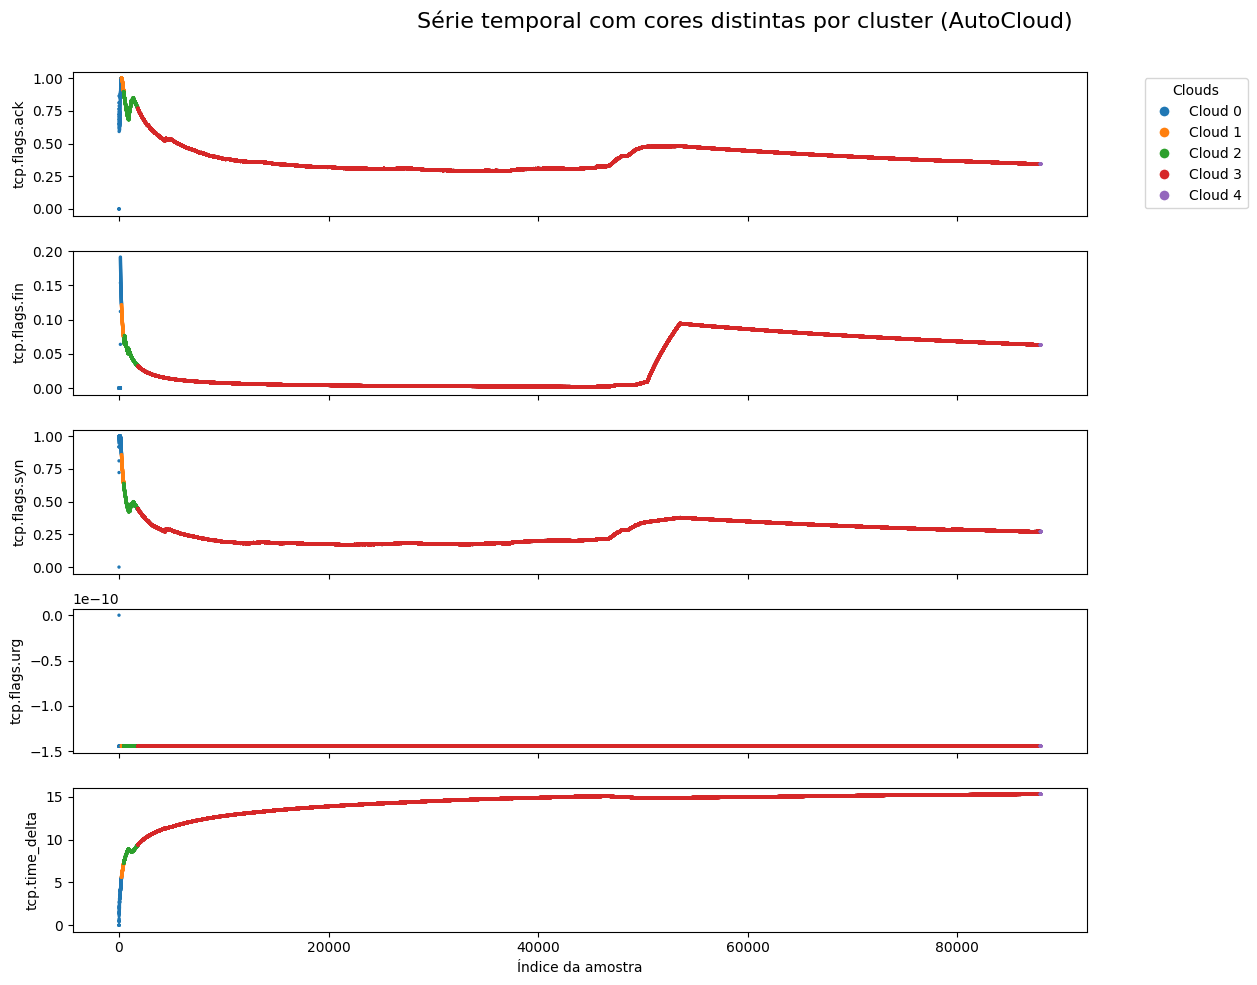

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.colors import TABLEAU_COLORS

#`ac.classIndex` tem os rótulos das clouds (mesmo comprimento das amostras processadas)

# Quantidade de amostras a visualizar
j = 88000
features_plot = features[:j]
classes = np.array(ac.classIndex[:j])

# Features que serão usadas
nomes = ['tcp.flags.ack', 'tcp.flags.fin', 'tcp.flags.syn', 'tcp.flags.urg', 'tcp.time_delta']

# Obter os clusters únicos e mapear cores bem distintas
clusters_unicos = sorted(set(classes))
num_clusters = len(clusters_unicos)

# Usar cores do TABLEAU_COLORS ou estender com outras se necessário
cores_disponiveis = list(TABLEAU_COLORS.values())
if num_clusters > len(cores_disponiveis):
    from matplotlib import cm
    cmap = cm.get_cmap('hsv', num_clusters)
    cores_disponiveis = [cmap(i) for i in range(num_clusters)]
    
# Mapeia índice da nuvem para uma cor única
mapa_cores = {c: cores_disponiveis[i] for i, c in enumerate(clusters_unicos)}
cores_amostras = [mapa_cores[c] for c in classes]

# Criar o gráfico com subplots para cada feature
fig, axs = plt.subplots(5, 1, figsize=(15, 10), sharex=True)

for i in range(5):
    axs[i].scatter(range(j), features_plot[:, i], c=cores_amostras, s=2)
    axs[i].set_ylabel(nomes[i])

axs[-1].set_xlabel('Índice da amostra')
fig.suptitle('Série temporal com cores distintas por clouds (AutoCloud)', fontsize=16)

# Criar a legenda
legenda_elementos = [
    Line2D([0], [0], marker='o', color='w', label=f'Cloud {c}', 
           markerfacecolor=cor, markersize=8) 
    for c, cor in mapa_cores.items()
]
axs[0].legend(handles=legenda_elementos, title="Clouds", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.85, 0.97])
plt.show()
